# In this notebook are some steps on how to use AltaiPony to extract flares from photometry, estimate flare energies and calculate flare frequency distributions (FFD)

# relevant imports and functions to use:

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt



def apply_altai(ID, input_LC,smoothed_input_LC,
               N1,N2,N3):
    '''
    This function is meant for detecting flares in photometry with AltaiPony.
    
    ============================================================
    Inputs:
    ID: ID number for target star, int or float
    input_LC: time,flux,error arrays, pandas dataframe
    smoothed_input_LC: detrended time,flux,error arrays, pandas dataframe
    N1: How many times above sigma is required, float 
    N2: How many times above sigma and detrended_flux_err is required, float
    N3: The number of consecutive points required to flag as a flare, float
    
    Outputs:
    
    Altai_flare_fits: table of measured flare parameters, pandas dataframe
    '''
    from altaipony.flarelc import FlareLightCurve
    from altaipony.lcio import from_mast
    # altaipony messes up matplotlib in jupyter notebook
    # add these lines
    import matplotlib as mpl
    mpl.rcParams.update(mpl.rcParamsDefault)
    %matplotlib inline
    
    cad = np.nanmedian(np.diff(smoothed_input_LC))
    
    flc = FlareLightCurve(time=input_LC['time'], \
                             flux=input_LC['flux'],\
                             flux_err=input_LC['flux_err'])
    flc.detrended_flux = smoothed_input_LC['flux']
    flc.detrended_flux_err = smoothed_input_LC['flux_err']
    flc.targetid=ID
    
    # turn off warnings since AltaiPony has deprecated pandas applications
    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)

    flc = flc.find_flares(N1=N1,N2=N2,N3=N3)
    flc = flc.flares.sort_values(by="ed_rec", ascending=False)
    
    Altai_flare_fits = pd.DataFrame({'tstart': flc['tstart'],
                               'tpeak': np.ones_like(flc['tstart'])*np.nan,
                               'Fpeak': flc['ampl_rec'],
                               'Npts': (flc['tstop']-flc['tstart'])/cad,
                               'equiv_dur': flc['ed_rec'],
                               'dur': flc['dur'],
                               'FWHM': np.ones_like(flc['tstart'])*np.nan,
                               'Validation': len(flc)*['Y']}).reset_index(drop=True)
    
    print(' ')
    
    return Altai_flare_fits


def FFD(LC_summary, TOTEXP=1., Lum=30., fluxerr=0., dur=[], 
        logY=True, est_comp=False,is_altai=True):
    '''
    Given a set of stellar flares, with accompanying durations light curve properties,
    compute the reverse cumulative Flare Frequency Distribution (FFD), and
    approximate uncertainties in both energy and rate (X,Y) dimensions.
    This diagram can be read as measuring the number of flares per day at a
    given energy or larger.
    Not a complicated task, just tedious.
    Y-errors (rate) are computed using Poisson upper-limit approximation from
    Gehrels (1986) "Confidence limits for small numbers of events in astrophysical data", https://doi.org/10.1086/164079
    Eqn 7, assuming S=1.
    X-errors (event energy) are computed following Signal-to-Noise approach commonly
    used for Equivalent Widths in spectroscopy, from
    Vollmann & Eversberg (2006) "Astronomische Nachrichten, Vol.327, Issue 9, p.862", https://dx.doi.org/10.1002/asna.200610645
    Eqn 6.
    Parameters
    ----------
    LC_summary : Pandas dataframe of measured flare parameters (tstart, tpeak, tstop, Fpeak, equiv_dur [days], dur [days])
    TOTEXP : total duration of observations, in days
    Lum : the log luminosity of the star
    fluxerr : the average flux errors of your data (in relative flux units!)
    dur : array of flare durations (in days).
    logY : if True return Y-axis (and error) in log rate (Default: True)
    est_comp : estimate incompleteness using histogram method, scale Y errors?
        (Default: True)
    is_altai: if True, accepts equiv_dur as in seconds already. if False, 
    converts from days to seconds
    Returns
    -------
    ffd_x, ffd_y, ffd_xerr, ffd_yerr
    X coordinate always assumed to be log_10(Energy)
    Y coordinate is log_10(N/Day) by default, but optionally is N/Day
    Upgrade Ideas
    -------------
    - More graceful behavior if only an array of flares and a total duration are
        specified (i.e. just enough to make ffd_x, ffd_y)
    - Better propogation of specific flux errors in the light curve, rather than
        average error used
    - Include detrending errors? (e.g. from a GP)
    - Asymmetric Poisson errors?
    - Better handling of incompleteness?
    '''
    import pandas as pd
    pd.options.mode.chained_assignment = None 
    from astropy.constants import iau2012 as const
    # reverse sort flares in Equiv Dur
    LC_summary=LC_summary.iloc[np.argsort(LC_summary['equiv_dur'].to_numpy())[::-1]]
    ED=LC_summary['equiv_dur']
    dur=LC_summary['dur'] #no duration...
    #
    # make ED & dur in seconds from days!
    if is_altai==False:
        ED = ED*24*60*60 # in seconds
    else:
        ED=ED
    
    # REVERSE sort the flares in energy
    #ss = np.argsort(np.array(ED))[::-1]
    #ffd_x = np.log10(ED[ss]) + Lum #ED must be in seconds for units of ffd_x to be in ergs
    
    ffd_x = np.log10(ED) + Lum #ED must be in seconds for units of ffd_x to be in ergs
    
    Num = np.arange(1, len(ffd_x)+1)
    ffd_y = Num / TOTEXP

    # approximate the Poisson Y errors using Gehrels (1986) eqn 7
    Perror = np.sqrt(Num + 0.75) + 1.0
    ffd_yerr = Perror / TOTEXP

    # estimate completeness using the cumulative distribution of the histogram
    if est_comp==True:
        # make very loose guess at how many bins to choose
        nbin = int(np.sqrt(len(ffd_x)))
        if nbin < 10:
            nbin=10 # but use at least 10 bins

        # make histogram of the log(energies)
        try:
            hh, be = np.histogram(ffd_x, bins=nbin, range=[np.nanmin(ffd_x), np.nanmax(ffd_x)])
        except ValueError:
            hh, be = np.histogram(ffd_x, bins=nbin, range=[0, np.nanmax(ffd_x)])
        hh = hh/np.nanmax(hh)
        # make cumulative distribution of the histogram, scale to =1 at the hist peak
        cc = np.cumsum(hh)/np.sum(hh[0:np.argmax(hh)])
        be = (be[1:]+be[0:-1])/2
        # make completeness = 1 for energies above the histogram peak
        cc[np.argmax(hh):] = 1
        # interpolate the cumulative histogram curve back to the original energies
        ycomp = np.interp(ffd_x, be, cc)
        # scale the y-errors by the completeness factor (i.e. inflate small energy errors)
        ffd_yerr = ffd_yerr / ycomp

    if logY:
        # transform FFD Y and Y Error into log10
        ffd_yerr = np.abs(ffd_yerr / np.log(10.) / ffd_y)
        ffd_y = np.log10(ffd_y)
        

    # compute X uncertainties for FFD
    if (len(dur)==len(ffd_x)):
        # assume relative flux error = 1/SN
        S2N = 1/fluxerr
        
        # based on Equivalent Width error
        # Eqn 6, Vollmann & Eversberg (2006) Astronomische Nachrichten, Vol.327, Issue 9, p.862
        ED_err = np.sqrt(2)*(dur* 24*60*60 - ED)/S2N
        ffd_xerr = np.abs((ED_err) / np.log(10.) / ED) # convert to log
    else:
        # not particularly meaningful, but an interesting shape. NOT reccomended
        # print('Warning: Durations not set. Making bad assumptions about the FFD X Error!')
        ffd_xerr = (1/np.sqrt(ffd_x-np.nanmin(ffd_x))/(np.nanmax(ffd_x)-np.nanmin(ffd_x)))
        
        
    #make sure values are finite ONLY (for polyfit reasons)
    
    LC_summary['ffd_x'] =    ffd_x
    LC_summary['ffd_xerr'] = ffd_xerr
    LC_summary['ffd_y'] =    ffd_y
    LC_summary['ffd_yerr'] = ffd_yerr    
    LC_summary=LC_summary.reset_index(drop=True)
    print('FFD len check:',len(ffd_x),len(ffd_xerr),len(ffd_y),len(ffd_yerr))
    #df = pd.DataFrame({'ffd_x':ffd_x,'ffd_xerr':ffd_xerr,'ffd_y':ffd_y,'ffd_yerr':ffd_yerr})
#     with pd.option_context('mode.use_inf_as_null', True):
#         df = df.dropna().reset_index(drop=True)
    #ffd_x,ffd_xerr,ffd_y,ffd_yerr = df['ffd_x'],df['ffd_xerr'],df['ffd_y'],df['ffd_yerr']
    #df=df.reset_index(drop=True)
#     return np.array(ffd_x), np.array(ffd_y), np.array(ffd_xerr), np.array(ffd_yerr), df
    return LC_summary


# Notes on calculating Flare Energy:

## See Eq 1 of https://iopscience.iop.org/article/10.3847/1538-4357/acbd36/pdf

# $E_{\mathrm{flare}} = \int L_{\mathrm{flare}}(t) dt = 2\pi R_{\mathrm{star}}^2 \times \sigma_{\mathrm{SB}}T_{\mathrm{eff}}^4 \times \frac{R(\lambda)B(\lambda, T_{\mathrm{eff}} d\lambda)}{R(\lambda)B(\lambda, T_{\mathrm{flare}} d\lambda)} \times \int \frac{\Delta F}{F}(t) dt$ 
## where 
## $\frac{R(\lambda)B(\lambda, T_{\mathrm{eff}} d\lambda)}{R(\lambda)B(\lambda, T_{\mathrm{flare}} d\lambda)} = \mathrm{"flux~ratio"}$ and $\int \frac{\Delta F}{F}(t) dt =~\mathrm{"equivalent~duration"}$

# so to simplify

$E_{\mathrm{flare}} = \mathrm{flux~ratio} \times 2\pi R_{\mathrm{star}}^2 \times \sigma_{\mathrm{SB}}T_{\mathrm{eff}}^4 \times \mathrm{equivalent~duration}$ 

In [2]:
def flare_factor(teff, radius, wav, resp,  tflare=float(1e4)):
    """Calculate the flare energy factor in ergs.

    Parameters
    ----------
    teff : float
        Stellar effective temperature in Kelvin.
    radius : float
        Stellar radius in solar radii.
    wav : array
        Array of wavelengths in nanometers.
    resp : array
        Array of bandpass responses.
     tflare : float
        Flare temperature in Kelvin. Default 10,000 K.
    
    Returns
    -------
    factor : float
        Flare energy factor in ergs/s.
    """
    from astropy.modeling import models
    from astropy import units as u
    from astropy.constants import sigma_sb

    # blackbody
    bb = models.BlackBody(temperature=teff * u.K)

    # blackbody flux in TESS band
    bbwavs = bb(wav * u.nm)  * resp

    fluxstar = np.trapz(bbwavs.value, wav)

    # blackbody
    bb = models.BlackBody(temperature=tflare * u.K)

    # blackbody flux in TESS band
    bbwavf = bb(wav * u.nm)  * resp

    fluxflare = np.trapz(bbwavf.value, wav)

    ratio = fluxstar / fluxflare

    #print("TESS", ratio)

    factor = ratio * np.pi * (radius * u.R_sun) ** 2 * sigma_sb * (tflare * u.K)**4
    factor = factor.to("erg/s")
    print(factor)
    return factor

kepler_bandpass = np.transpose(np.loadtxt('https://nexsci.caltech.edu/workshop/2012/keplergo/kepler_response_hires1.txt', skiprows=6, comments='#',encoding='utf-16'))
kepler_bandpass = pd.DataFrame({'Wavelength (nm)':kepler_bandpass[0], 'lambda Transmission':kepler_bandpass[1]})
tess_bandpass = pd.read_csv('https://heasarc.gsfc.nasa.gov/docs/tess/data/tess-response-function-v2.0.csv',skiprows=5)
tess_bandpass=tess_bandpass.rename(columns={'# Wavelength (nm)':'Wavelength (nm)',' lambda Transmission':'lambda Transmission' })


tess_bandpass['Wavelength (Angstrom)'] = tess_bandpass['Wavelength (nm)']*10
kepler_bandpass['Wavelength (Angstrom)'] = kepler_bandpass['Wavelength (nm)']*10



# example: YZ CMi

# grab 2min TESS light curves (this might take a few minutes...)

In [3]:
import lightkurve as lk
from lightkurve import search_targetpixelfile

starname='TIC 266744225'
ID=int(starname[4:])

tpf_search = search_targetpixelfile(starname) #this will get tpfs for custom extraction, above method gets light curves from SPOC
tpf_search_SPOC = tpf_search[tpf_search.author=='SPOC']
tpf_search_SPOC = tpf_search_SPOC[tpf_search_SPOC.exptime.value>20]
tpf_search_SPOC

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 07,2019,SPOC,120,266744225,0.0
1,TESS Sector 34,2021,SPOC,120,266744225,0.0


In [4]:
import os,sys
S7tpf = tpf_search_SPOC[0].download(quality_bitmask='hardest',download_dir=os.getcwd()+'/')
S34tpf= tpf_search_SPOC[1].download(quality_bitmask='hardest',download_dir=os.getcwd()+'/')

In [5]:
def query_region_for_nearby_stars(ID,radial_cone_in_arcsecs):
    #stuff for getting FFI data from MAST
    from astroquery.mast import Catalogs
    import numpy as np
    import time as clock
    import requests

    starName="TIC "+str(ID)
    radial_cone = radial_cone_in_arcsecs/ 3600.0 # angular radius in degrees
    try:
        catalogData = Catalogs.query_object(starName, radius = radial_cone, catalog = "TIC")
    except requests.exceptions.ConnectionError as E:
        clock.sleep(5) #pause 5 seconds then try again
        catalogData = Catalogs.query_object(starName, radius = radSearch, catalog = "TIC")
    #    
    return catalogData

def convert_TessMag_to_Flux(Tmag):
    f = 10**(-(Tmag/2.5))
    return f

def calc_flux_contamination(ID,radial_cone_in_arcseconds=63):

    catalogData = query_region_for_nearby_stars(ID,radial_cone_in_arcseconds)

    Tmag_target_star = catalogData[0]['Tmag']
    Flux_target_star = convert_TessMag_to_Flux(Tmag_target_star)
    Flux_all = []
    for t in range(len(catalogData)):
        Flux_all = np.append(Flux_all, convert_TessMag_to_Flux(catalogData[t]['Tmag']))
    Flux_total = np.sum(Flux_all)

    flux_contamination_ratio = Flux_target_star / Flux_total #this is light FROM the target star
    flux_contamination_ratio = 1 - Flux_target_star / Flux_total #this is light NOT FROM the target star (will produce ratio=0 for 1 - 10^(-Tmag,target/2.5) / 10^(-Tmag,target/2.5)

    return flux_contamination_ratio

def Extract_LC(lk_object,threshold,bkg_threshold,TPForFFI):
    import pandas as pd
    if TPForFFI=='TPF':
        target_mask = lk_object.hdu[2].data & 2 > 0 #SPOC optimal aperture
    else:    
        target_mask = lk_object.create_threshold_mask(threshold=threshold, reference_pixel='center')
    
    n_target_pixels = target_mask.sum()
    target_lc = lk_object.to_lightcurve(aperture_mask=target_mask)
    background_mask = ~lk_object.create_threshold_mask(threshold=bkg_threshold, reference_pixel=None)
    n_background_pixels = background_mask.sum()

    
    background_lc_per_pixel = lk_object.to_lightcurve(aperture_mask=background_mask) / n_background_pixels
    background_estimate_lc = background_lc_per_pixel * n_target_pixels
    raw_bkg=background_estimate_lc.remove_nans()
    norm_bkg=background_estimate_lc.normalize()
    cnew=target_lc - background_estimate_lc.flux
    cnew=cnew.remove_nans()#.remove_outliers() #<---- this truncates transits!!!
    
    raw_lc=target_lc#cnew
    corrected_lc = cnew.normalize()
    
    quality_mask = np.where(corrected_lc.quality==0)[0]
    
    corrected_lc = corrected_lc[quality_mask]
    norm_bkg = norm_bkg[quality_mask]
    raw_lc = raw_lc[quality_mask]
    raw_bkg = raw_bkg[quality_mask]
    
    
    #b/c new lightkurve is weird and now requires .value for arrays, use pandas
    
    
    #deblend all light curves within 2 TESS pixels
    f_contam_ratio = calc_flux_contamination(ID,radial_cone_in_arcseconds=21*2)
    
    deblended_corrected_lc_flux = corrected_lc.flux.value - f_contam_ratio
    deblended_corrected_lc_flux = deblended_corrected_lc_flux / np.nanmedian(deblended_corrected_lc_flux)
    
    deblended_raw_lc_flux = raw_lc.flux.value - f_contam_ratio
    deblended_raw_lc_flux = deblended_raw_lc_flux #/ np.nanmedian(deblended_raw_lc_flux)
    
    corrected_lc = pd.DataFrame({'time':corrected_lc.time.value,'flux':deblended_corrected_lc_flux,\
                                'flux_err':corrected_lc.flux_err.value})
    norm_bkg = pd.DataFrame({'time':norm_bkg.time.value,'flux':norm_bkg.flux.value,\
                                'flux_err':norm_bkg.flux_err.value})
    raw_lc = pd.DataFrame({'time':raw_lc.time.value,'flux':deblended_raw_lc_flux,\
                                'flux_err':raw_lc.flux_err.value})
    raw_bkg = pd.DataFrame({'time':raw_bkg.time.value,'flux':raw_bkg.flux.value,\
                                'flux_err':raw_bkg.flux_err.value})
    
    #for PLD detrending later
    
#     print(corrected_lc.time.value)
#     print(deblended_corrected_lc_flux)
#     print(corrected_lc.flux_err.value)
#     print(deblended_raw_lc_flux)
#     print(raw_bkg.flux.value)
    
    master_lc = pd.DataFrame({'Time':np.array(corrected_lc['time']),\
                              'SAP Flux':deblended_corrected_lc_flux,\
                              'SAP Error':np.array(corrected_lc['flux_err']),\
                              'RAW SAP Flux':deblended_raw_lc_flux,\
                              'Background Flux':np.array(raw_bkg['flux'])})
    
    
    return corrected_lc, norm_bkg, raw_lc, raw_bkg, master_lc

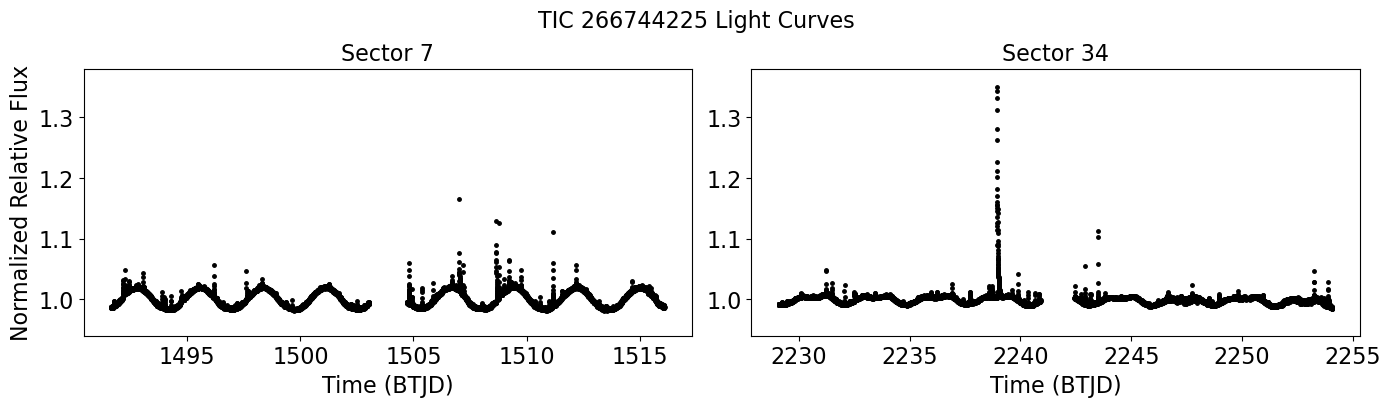

In [7]:
S7_TPF_LC, S7_TPF_BKG, S7_TPF_RAWLC, S7_TPF_RAWBKG, S7_TPF_master  = Extract_LC(S7tpf, threshold=3,bkg_threshold=1/1000,TPForFFI='TPF')
S34_TPF_LC,S34_TPF_BKG,S34_TPF_RAWLC,S34_TPF_RAWBKG,S34_TPF_master = Extract_LC(S34tpf,threshold=3,bkg_threshold=1/1000,TPForFFI='TPF')

# Let's see what the photometry looks like:

fs=16
fig=plt.figure(figsize=(14,7))
ax1=fig.add_subplot(221)
ax2=fig.add_subplot(222)


def plot_LC(LC,ax,label):
    try:
        ax.plot(LC.time,LC.flux,'k.',markersize=5)
        ax.set_ylim(np.nanmin(LC.flux)-3*np.nanstd(LC.flux),np.nanmax(LC.flux)+3*np.nanstd(LC.flux))
    except AttributeError: #for PLD detrended LCs, later
        ax.plot(LC['Time'],LC['PLD Flux'],'k.',markersize=5)
        ax.set_ylim(np.nanmin(LC['PLD Flux'])-3*np.nanstd(LC['PLD Flux']),np.nanmax(LC['PLD Flux'])+3*np.nanstd(LC['PLD Flux']))        
    ax.tick_params(axis='both', which='major', labelsize=fs)
    ax.set_xlabel('Time (BTJD)',fontsize=fs)
    ax.set_rasterized(True)
    ax.set_title(label,fontsize=fs)
    
ax1.set_ylabel('Normalized Relative Flux',fontsize=fs)    

plot_LC(S7_TPF_LC,ax1,label='Sector 7')
plot_LC(S34_TPF_LC,ax2,label='Sector 34')

ymin,ymax = np.min([ax1.get_ylim(),ax2.get_ylim()]),np.max([ax1.get_ylim(),ax2.get_ylim()])
ax1.set_ylim(ymin,ymax)
ax2.set_ylim(ymin,ymax)

fig.suptitle(starname+' Light Curves',x=0.5,y=0.975,fontsize=fs)
fig.tight_layout(pad=1)
plt.show()


# Smooth LC for easier detection (use your favorite algorithm!)



Smoothing Window in days: 0.5 ; in data points: 361


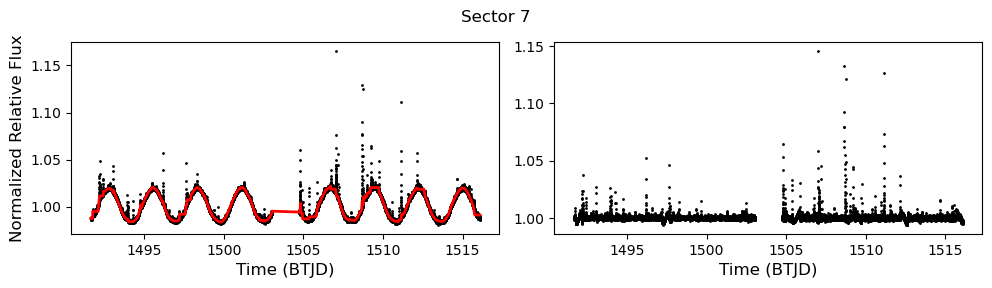

Smoothing Window in days: 0.5 ; in data points: 361


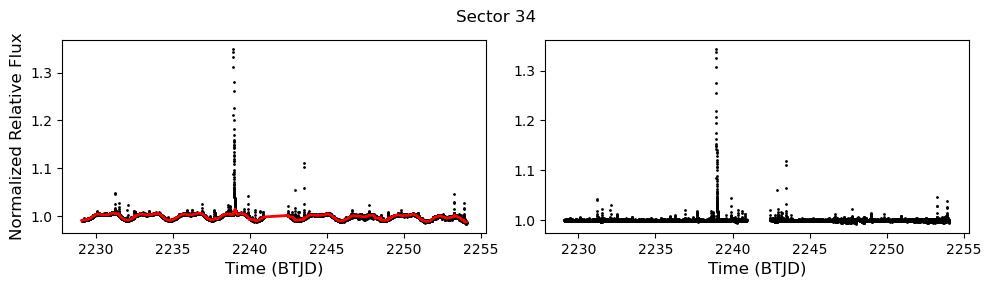

In [8]:
# I'll use lightkurve's savitsky-golay filter (which is pretty commonly used)

def detrend(input_LC,window_size,polyorder):

    import lightkurve as lk


    cadence = np.nanmedian(np.diff(input_LC.time))
    def round_up_to_odd(f): #must be an odd number!
        return int(np.ceil(f) // 2 * 2 + 1)
    Npts = round_up_to_odd(int((window_size)/cadence)) 
    print('Smoothing Window in days:',window_size,'; in data points:',Npts)
    
    detrended_lc,trend_lc = lk.LightCurve(time=input_LC.time,
                                          flux=input_LC.flux,
                                          flux_err=input_LC.flux_err).flatten(window_length=Npts,
                                                                              polyorder=polyorder, 
                                                                              return_trend=True)
    #instead of retuning lk.LightCurve, return pandas dataframe instead
    import pandas as pd
    detrended_lc = pd.DataFrame({'time':detrended_lc.time.value,
                                'flux':detrended_lc.flux.value,
                                'flux_err':detrended_lc.flux_err.value})
    trend_lc = pd.DataFrame({'time':trend_lc.time.value,
                             'flux':trend_lc.flux.value,
                             'flux_err':trend_lc.flux_err.value})
    return detrended_lc,trend_lc

S7_detrended_lc, S7_trend_lc = detrend(input_LC = S7_TPF_LC,
                            window_size=12/24,
                            polyorder=3)

fs=12
fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(221)
ax2=fig.add_subplot(222)

ax.scatter(S7_TPF_LC.time,S7_TPF_LC.flux,color='black',s=1)
ax.plot(S7_trend_lc.time,S7_trend_lc.flux,color='red',lw=2)
ax2.scatter(S7_detrended_lc.time,S7_detrended_lc.flux,color='black',s=1)
fig.suptitle('Sector 7',x=0.5,y=0.975)
ax.set_ylabel('Normalized Relative Flux',fontsize=fs)    
ax.set_xlabel('Time (BTJD)',fontsize=fs)
ax2.set_xlabel('Time (BTJD)',fontsize=fs)
fig.tight_layout(pad=1)
plt.show()


S34_detrended_lc, S34_trend_lc = detrend(input_LC = S34_TPF_LC,
                            window_size=12/24,
                            polyorder=3)

fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(221)
ax2=fig.add_subplot(222)
ax.scatter(S34_TPF_LC.time,S34_TPF_LC.flux,color='black',s=1)
ax.plot(S34_trend_lc.time,S34_trend_lc.flux,color='red',lw=2)
ax2.scatter(S34_detrended_lc.time,S34_detrended_lc.flux,color='black',s=1)
fig.suptitle('Sector 34',x=0.5,y=0.975)
ax.set_ylabel('Normalized Relative Flux',fontsize=fs)    
ax.set_xlabel('Time (BTJD)',fontsize=fs)
ax2.set_xlabel('Time (BTJD)',fontsize=fs)
fig.tight_layout(pad=1)
plt.show()

# Next, use AltaiPony to detect flares. I recommend defining N1 = 2, N2=1 and defining N3 based on cadence of the light curve

In [9]:
N1=2
N2=1

if np.nanmedian(np.diff(S7_detrended_lc['time']))*24*60*60 < 60:
    N3=5    
if (np.nanmedian(np.diff(S7_detrended_lc['time']))*24*60*60 > 60)  & (np.nanmedian(np.diff(S7_detrended_lc['time']))*24*60 <= 30):
    N3=3
print(N1,N2,N3)    


flc_7 = apply_altai(ID=ID, 
                    input_LC=S7_TPF_LC,
                    smoothed_input_LC=S7_detrended_lc,
                    N1=N1,N2=N2,N3=N3)
flc_34 = apply_altai(ID=ID, 
                     input_LC=S34_TPF_LC,
                     smoothed_input_LC=S34_detrended_lc,
                     N1=N1,N2=N2,N3=N3)

# how to combine the light curves 
input_LC = S7_TPF_LC.append(S34_TPF_LC)
smoothed_input_LC = S7_detrended_lc.append(S34_detrended_lc)

flc_7_and_34 = apply_altai(ID=ID, input_LC=input_LC,
                           smoothed_input_LC=smoothed_input_LC,
                           N1=N1,N2=N2,N3=N3)

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
%matplotlib inline

2 1 3


/Users/daxfeliz/opt/anaconda3/lib/python3.9/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Users/daxfeliz/opt/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
Found 100 candidate(s) in the (0,8152) gap.
Found 104 candidate(s) in the (8152,16299) gap.


Found 87 candidate(s) in the (0,8480) gap.
Found 102 candidate(s) in the (8480,16794) gap.


Found 100 candidate(s) in the (0,8152) gap.
Found 104 candidate(s) in the (8152,16299) gap.
Found 87 candidate(s) in the (16299,24779) gap.
Found 102 candidate(s) in the (24779,33093) gap.


# estimate flare energy based on Kepler, TESS passbands and a blackbody of a given temperature 

In [10]:
# from Baroach et al. 2020 https://www.aanda.org/articles/aa/pdf/2020/09/aa38213-20.pdf
R_star = 0.369
R_star_unc= np.mean([0.027,0.055])
M_star = R_star #ASSUMPTION, NOT LISTED
M_star_unc = R_star_unc #ASSUMPTION, NOT LISTED
Teff = 3100
Teff_unc = np.mean([50])
distance = 5.9874 #pc
logg =  5


# ex usage: 
print('TESS flare energy for 10,000 K flare')
tess_flare_factor = flare_factor(teff=Teff, radius=R_star, wav = tess_bandpass["Wavelength (nm)"].values, resp=tess_bandpass["lambda Transmission"].values)    
print(' ')
print('Kepler flare energy for 10,000 K flare')
kepler_flare_factor = flare_factor(teff=Teff, radius=R_star, wav = kepler_bandpass["Wavelength (nm)"].values, resp=kepler_bandpass["lambda Transmission"].values)    
print(' ')
# nflares["ed_rec"] = nflares.ed_rec * factor.value
# nflares["ed_rec_err"] = nflares.ed_rec_err * factor.value


TESS flare energy for 10,000 K flare
1.7013422141179704e+31 erg / s
 
Kepler flare energy for 10,000 K flare
8.065932111567394e+30 erg / s
 


In [11]:
# calculate total exposure time (cadence times LC duration)
tess_exp_7 = np.nanmedian(np.diff(S7_detrended_lc.time))  * len(S7_detrended_lc.time)
tess_exp_34 = np.nanmedian(np.diff(S34_detrended_lc.time))  * len(S34_detrended_lc.time)
tess_exp_7_and_34 = np.nanmedian(np.diff(smoothed_input_LC.time))  * len(smoothed_input_LC.time)

# provide flux uncertainties
flux_err_7 = np.nanmedian(S7_detrended_lc.flux_err)
flux_err_34 = np.nanmedian(S34_detrended_lc.flux_err)
flux_err_7_and_34 = np.nanmedian(smoothed_input_LC.flux_err)


# plot FFD distributions

FFD len check: 204 204 204 204
FFD len check: 189 189 189 189
FFD len check: 393 393 393 393


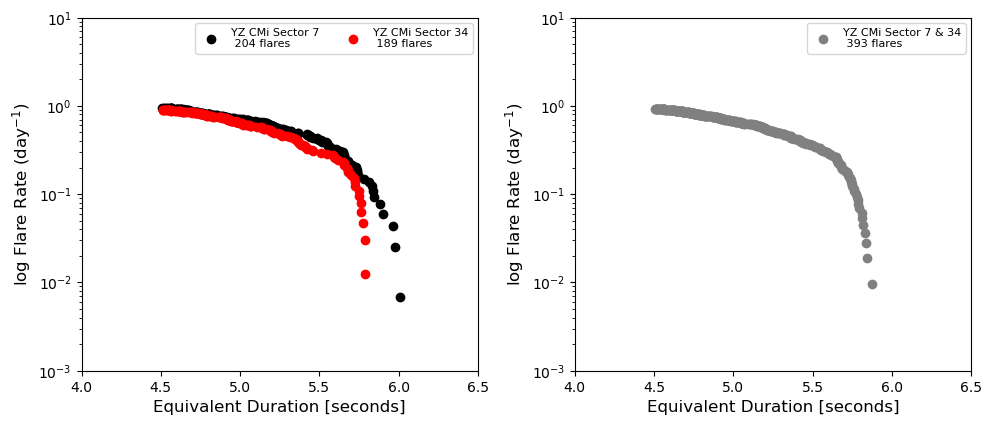



FFD len check: 204 204 204 204
FFD len check: 189 189 189 189
FFD len check: 393 393 393 393


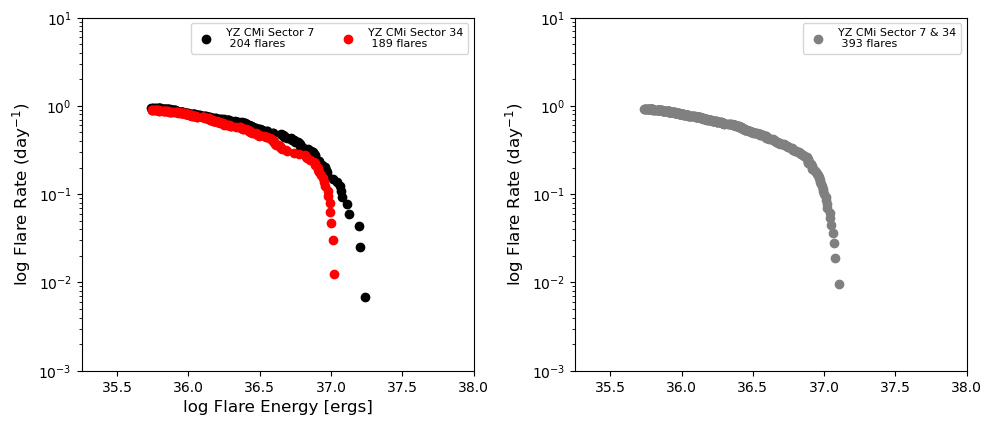

In [12]:


# if we set flare luminosity to zero, the "flare energies"
# are equal to the equivalent durations of the flares
Lflare = 0

flc_7_ffd = FFD(flc_7, TOTEXP=tess_exp_7, 
                Lum=Lflare, fluxerr=flux_err_7, dur=[], 
                logY=True, est_comp=False,is_altai=False)

flc_34_ffd = FFD(flc_34, TOTEXP=tess_exp_34, 
                   Lum=Lflare, fluxerr=flux_err_34, dur=[], 
        logY=True, est_comp=False,is_altai=False)

flc_7_and_34_ffd = FFD(flc_7_and_34, TOTEXP=tess_exp_7_and_34, 
                         Lum=Lflare, fluxerr=flux_err_7_and_34, dur=[], 
        logY=True, est_comp=False,is_altai=False)



fig=plt.figure(figsize=(10,8))
ax1=fig.add_subplot(221)
ax2=fig.add_subplot(222)


ax1.scatter(flc_7_ffd['ffd_x'],flc_7_ffd['ffd_y'],label='YZ CMi Sector 7\n '+str(len(flc_7_ffd))+' flares',color='black')
ax1.scatter(flc_34_ffd['ffd_x'],flc_34_ffd['ffd_y'],label='YZ CMi Sector 34\n '+str(len(flc_34_ffd))+' flares',color='red')

ax2.scatter(flc_7_and_34_ffd['ffd_x'],flc_7_and_34_ffd['ffd_y'],label='YZ CMi Sector 7 & 34\n '+str(len(flc_7_and_34_ffd))+' flares',color='grey')


# plt.xlim(35.5,38)
ax1.set_yscale('log')
ax1.set_xlabel('Equivalent Duration [seconds]',fontsize=12)
ax1.set_ylabel('log Flare Rate (day$^{-1}$)',fontsize=12)

ax2.set_yscale('log')
ax2.set_xlabel('Equivalent Duration [seconds]',fontsize=12)
ax2.set_ylabel('log Flare Rate (day$^{-1}$)',fontsize=12)


ymin,ymax= 1e-3,10
ax1.set_ylim(ymin,ymax)
ax2.set_ylim(ymin,ymax)

ymin,ymax = np.min([ax1.get_ylim(),ax2.get_ylim()]),np.max([ax1.get_ylim(),ax2.get_ylim()])
ax1.set_ylim(ymin,ymax)
ax2.set_ylim(ymin,ymax)

xmin,xmax = 4,6.5
ax1.set_xlim(xmin,xmax)
ax2.set_xlim(xmin,xmax)


ax1.legend(loc='upper right',fontsize=8,ncol=2)#,bbox_to_anchor=(1,1))
ax2.legend(loc='upper right',fontsize=8,ncol=2)#,bbox_to_anchor=(1,1))

fig.tight_layout(pad=1)
plt.show()

print('\n==========================================\n')

# now let's use an actual flare energy
Lflare = np.log10(tess_flare_factor.value)

flc_7_ffd = FFD(flc_7, TOTEXP=tess_exp_7, 
                Lum=Lflare, fluxerr=flux_err_7, dur=[], 
                logY=True, est_comp=False,is_altai=False)

flc_34_ffd = FFD(flc_34, TOTEXP=tess_exp_34, 
                   Lum=Lflare, fluxerr=flux_err_34, dur=[], 
        logY=True, est_comp=False,is_altai=False)

flc_7_and_34_ffd = FFD(flc_7_and_34, TOTEXP=tess_exp_7_and_34, 
                         Lum=Lflare, fluxerr=flux_err_7_and_34, dur=[], 
        logY=True, est_comp=False,is_altai=False)

fig=plt.figure(figsize=(10,8))
ax1=fig.add_subplot(221)
ax2=fig.add_subplot(222)


ax1.scatter(flc_7_ffd['ffd_x'],flc_7_ffd['ffd_y'],label='YZ CMi Sector 7\n '+str(len(flc_7_ffd))+' flares',color='black')
ax1.scatter(flc_34_ffd['ffd_x'],flc_34_ffd['ffd_y'],label='YZ CMi Sector 34\n '+str(len(flc_34_ffd))+' flares',color='red')

ax2.scatter(flc_7_and_34_ffd['ffd_x'],flc_7_and_34_ffd['ffd_y'],label='YZ CMi Sector 7 & 34\n '+str(len(flc_7_and_34_ffd))+' flares',color='grey')


# plt.xlim(35.5,38)
ax1.set_yscale('log')
ax1.set_xlabel('log Flare Energy [ergs]',fontsize=12)
ax1.set_ylabel('log Flare Rate (day$^{-1}$)',fontsize=12)

ax2.set_yscale('log')
ax1.set_xlabel('log Flare Energy [ergs]',fontsize=12)
ax2.set_ylabel('log Flare Rate (day$^{-1}$)',fontsize=12)


ymin,ymax= 1e-3,10
ax1.set_ylim(ymin,ymax)
ax2.set_ylim(ymin,ymax)

ymin,ymax = np.min([ax1.get_ylim(),ax2.get_ylim()]),np.max([ax1.get_ylim(),ax2.get_ylim()])
ax1.set_ylim(ymin,ymax)
ax2.set_ylim(ymin,ymax)

xmin,xmax = 35.75-0.5,38
ax1.set_xlim(xmin,xmax)
ax2.set_xlim(xmin,xmax)


ax1.legend(loc='upper right',fontsize=8,ncol=2)#,bbox_to_anchor=(1,1))
ax2.legend(loc='upper right',fontsize=8,ncol=2)#,bbox_to_anchor=(1,1))

fig.tight_layout(pad=1)
plt.show()

In [13]:
print('all done! :D')

all done! :D
